In [1]:
from collections import OrderedDict
from time import time
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim
import torch.nn as nn

import hxtorch
import _hxtorch
import hxtorch.nn as hxnn

import FrEIA.framework as Ff
import FrEIA.modules as Fm

import quantized_cINN.common as com

## generate some data

In [2]:
class ExampleDataset(torch.utils.data.Dataset):

    def __init__(self, n_samples=100000, img_size=(2, 2), transform=None):
        self.n_samples = n_samples
        self.img_size = img_size
        self.transform = transform
        self.data, self.targets = self._generate_data()

    def _generate_data(self):
        floor = 0.2
        intensity = (0, 1)

        high = self.img_size[0] * self.img_size[1]
        labels = torch.randint(low=0, high=high, size=(self.n_samples, ))
        imgs = floor * torch.rand((self.n_samples, 1, *self.img_size))
        imgs[torch.arange(self.n_samples), :, labels%2, labels//2] += intensity[1] - floor 
        return imgs, labels

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
    
        X = self.data[idx].numpy()
        y = self.targets[idx].reshape(-1).numpy()
        if self.transform:
            X = self.transform(X)
        return X, y

class ExampleData:

    def __init__(self, config: object):
        from torch.utils.data import Dataset, DataLoader, TensorDataset
        import torchvision.transforms as T

        self.c = config

        self.train_data = ExampleDataset(transform=T.ToTensor())
        self.test_data = ExampleDataset(transform=T.ToTensor())

        # Sample a fixed batch of 1024 validation examples
        self.val_x, self.val_l = zip(*list(self.train_data[i] for i in range(1024)))
        self.val_x = torch.stack(self.val_x, 0).to(config.device)
        self.val_l = torch.LongTensor(self.val_l).to(config.device)

        # Exclude the validation batch from the training data
        self.train_data.data = self.train_data.data[1024:]
        self.train_data.targets = self.train_data.targets[1024:]

        ## Add the noise-augmentation to the (non-validation) training data:
        #augm_func = lambda x: x + self.c.add_image_noise * torch.randn_like(x)
        #self.train_data.transform = T.Compose([self.train_data.transform, augm_func])

        self.train_loader = DataLoader(self.train_data,
                                       batch_size=self.c.batch_size,
                                       shuffle=True,
                                       num_workers=self.c.n_workers,
                                       pin_memory=True, drop_last=True)
        self.test_loader = DataLoader(self.test_data,
                                      batch_size=self.c.batch_size,
                                      shuffle=False,
                                      num_workers=self.c.n_workers,
                                      pin_memory=True, drop_last=True)

## configuaration

In [3]:
class CONFIG(com.baseCONFIG):
    """
    Namspace for configuration
    """
    # Data
    data_mean = None
    data_std = None
    add_image_noise = None

    img_size = (2, 2)
    device = "cpu"
    n_workers = 8

    mock = True

    # Training
    lr = 1e-3
    batch_size = 256
    weight_decay = 1e-5
    gamma = 0.1
    milestones = [20, 40]
    betas = (0.9, 0.999)

    n_epochs = 20

    init_scale = 0.03
    pre_low_lr = 0
    
    clip_grad_norm = 100.0

    # Architecture
    n_blocks = 8
    internal_width = 16
    clamping = 1.0
    fc_dropout = 0.0

    # Logging/preview
    loss_names = ['L']
    preview_upscale = 3                         # Scale up the images for preview
    sampling_temperature = 0.8                  # Sample at a reduced temperature for the preview
    progress_bar = True                         # Show a progress bar of each epoch
    eval_steps_interploation = 12
    eval_seeds_interpolation  = (51, 89)

    # Validation
    pca_weights = [
        [(0,0.55)],
        [(1,0.1), (3, 0.4), (4, 0.5)],
        [(2,0.33), (3, 0.33), (1, -0.33)]]
    pca_gridsize = 10
    pca_extent = 8.


    # Paths
    mnist_data = "aml-cinn/mnist_data"
    save_dir = "out_hx_mock/"

    load_file = "out_hx_mock/hx_mock_example_checkpoint.pt"
    filename = "out_hx_mock/hx_mock_example_cinn.pt"

    checkpoint_save_interval =  20
    checkpoint_save_overwrite = True
    checkpoint_on_error = True

## model

In [37]:
class ShiftNScale(nn.Module):

    def __init__(self, shift=0., scale=1.):
        super().__init__()
        self.shift = shift
        self.scale = scale

    def forward(self, x):
        print("Subnet output scaling")
        print(f"\tbefore scaling\trange ({torch.min(x):.2f}, {torch.max(x):.2f})\tvalue {torch.mean(x):.2f}+/-{torch.std(x):.2f}")
        x = (x - torch.mean(x)) / torch.std(x)
        x = x * self.scale + self.shift
        print(f"\tafter scaling\trange ({torch.min(x):.2f}, {torch.max(x):.2f})\tvalue {torch.mean(x):.2f}+/-{torch.std(x):.2f}")
        return x

class EXAMPLEcINN_hx(nn.Module):
    """
    """

    def __init__(self, config: object=CONFIG):
        super().__init__()
        self.stop = False

        self.c = config

        self.cinn = self.build_inn()

        self.trainable_parameters = [p for p in self.cinn.parameters() if p.requires_grad]
        for p in self.trainable_parameters:
            p.data = self.c.init_scale * torch.randn_like(p)

        self.cinn.to(self.c.device)

        self.optimizer = torch.optim.Adam(self.trainable_parameters,
                                          lr=self.c.lr,
                                          weight_decay=self.c.weight_decay)
        self.weight_scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer,
                                                                #step_size=1,
                                                                milestones=self.c.milestones,
                                                                gamma=self.c.gamma)

    def build_inn(self):

        def fc_subnet(ch_in, ch_out):
            net = OrderedDict([
                ("lin_1", hxnn.Linear(in_features=ch_in,
                                      out_features=self.c.internal_width,
                                      bias=True,
                                      num_sends=2,
                                      wait_between_events=2,
                                      mock=self.c.mock,
                                      input_transform=self.scale_input_clamp)),
                ("relu1", hxnn.ConvertingReLU(shift=1,
                                              mock=True)),
                #("relu1", nn.ReLU()),
                ("lin_2", hxnn.Linear(in_features=self.c.internal_width,
                                      out_features=ch_out,
                                      bias=False,
                                      num_sends=3,
                                      wait_between_events=2,
                                      mock=self.c.mock,
                                      input_transform=self.scale_input_clamp)),
                ("resca", ShiftNScale())
            ])
            return nn.Sequential(net)

        cond = Ff.ConditionNode(4)

        nodes = [Ff.InputNode(1, *self.c.img_size)]
        nodes.append(Ff.Node(nodes[-1], Fm.Flatten, {}))

        for k in range(self.c.n_blocks):
            nodes.append(Ff.Node(nodes[-1], Fm.PermuteRandom,
                                 {"seed": k}))
            nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock,
                                 {"subnet_constructor": fc_subnet,
                                  "clamp": self.c.clamping},
                                  conditions=cond))

        nodes += [cond, Ff.OutputNode(nodes[-1])]
        return Ff.ReversibleGraphNet(nodes, verbose=False)

    @staticmethod
    def scale_input_clamp(x_in: torch.Tensor) -> torch.Tensor:
        print(f"Subnet input scaling")
        print(f"\tbefore scaling\trange ({torch.min(x_in):.2f}, {torch.max(x_in):.2f})\tvalue {torch.mean(x_in):.2f}+/-{torch.std(x_in):.2f}")

        max_in = torch.max(torch.cat((x_in, -x_in)))
        shift = _hxtorch.constants.input_activation_max // 2
        factor = shift / max_in if max_in > 0 else 1
        x_in = x_in * factor + shift
        print(f"\tafter scaling\trange ({torch.min(x_in):.2f}, {torch.max(x_in):.2f})\tvalue {torch.mean(x_in):.2f}+/-{torch.std(x_in):.2f}")
        return x_in

    def forward(self, x, l, jac=True):
        if self.stop:
            raise
        self.stop = True
        print(x[0])
        return self.cinn(x, c=one_hot(l), jac=jac)

    def reverse_sample(self, z, l, jac=True):
        return self.cinn(z, c=one_hot(l), rev=True, jac=jac)

    def save(self, name):
        save_dict = {"opt": self.optimizer.state_dict(),
                     "net": self.cinn.state_dict(),
                     "lr": self.weight_scheduler.state_dict()}
        torch.save(save_dict, name)

    def load(self, name):
        state_dicts = torch.load(name)
        self.cinn.load_state_dict(state_dicts["net"])
        try:
            self.optimizer.load_state_dict(state_dicts["opt"])
        except ValueError:
            print("Cannot load optimizer for some reason or other")
        try:
            self.weight_scheduler.load_state_dict(state_dicts["lr"])
        except ValueError:
            print("Cannot load optimizer for some reason or other")

    def fuse_model(self):
        for m in self.cinn.modules():
            if type(m) == nn.Sequential:
                try:
                    torch.quantization.fuse_modules(m, ["lin_1", "relu1"], inplace=True)
                except AssertionError:
                    print("fuse_model failed here:", m)

    def quantize(self, calibration: callable=None):
        self.eval()
        self.fuse_model()
        self.qconfig = torch.quantization.default_qconfig

        torch.quantization.prepare(self, inplace=True)

        if calibration:
            calibration(self)

        torch.quantization.convert(self, inplace=True)

            
def one_hot(labels, out=None):
    '''
    Convert LongTensor labels (contains labels 0-9), to a one hot vector.
    Can be done in-place using the out-argument (faster, re-use of GPU memory)
    '''
    if out is None:
        out = torch.zeros(labels.shape[0], 4).to(labels.device)
    else:
        out.zeros_()
    out.scatter_(dim=1, index=labels.view(-1,1), value=1.)
    return out

## train

In [38]:
config = CONFIG()
config.n_epochs = 5
data = ExampleData(config)

model_floating = EXAMPLEcINN_hx(config)

t_start = time()

model_floating.train()
nll_mean = []


try:
    for i_epoch in range(-config.pre_low_lr, config.n_epochs):
        if i_epoch < 0:
            for param_group in model.optimizer.param_groups:
                param_group['lr'] = config.lr * 2e-2

        for i_batch, (x, l) in enumerate(data.train_loader):

            x, l = x.to(config.device), l.to(config.device)
            z, log_j = model_floating(x, l)

            nll = torch.mean(z**2) / 2 - torch.mean(log_j) / np.prod(config.img_size)
            nll.backward()
            torch.nn.utils.clip_grad_norm_(model_floating.trainable_parameters,
                                           config.clip_grad_norm)

            nll_mean.append(nll.item())

            model_floating.optimizer.step()
            model_floating.optimizer.zero_grad()

            if not i_batch % 50:
                with torch.no_grad():
                    z, log_j = model_floating(data.val_x, data.val_l)
                    nll_val = torch.mean(z**2) / 2 - torch.mean(log_j) / np.prod(config.img_size)

                print('%.3i \t%.5i/%.5i \t%.2f \t%.6f\t%.6f\t%.2e' % (i_epoch,
                                                                i_batch, len(data.train_loader),
                                                                (time() - t_start)/60.,
                                                                np.mean(nll_mean),
                                                                nll_val.item(),
                                                                model_floating.optimizer.param_groups[0]['lr'],
                                                                ), flush=True)
                nll_mean = []

        model_floating.weight_scheduler.step()

        if (i_epoch % config.checkpoint_save_interval) == 0:
            model_floating.save(config.filename + 'floating_checkpoint_%.4i' % (i_epoch * (1-config.checkpoint_save_overwrite)))

    #model_fp32.save(config.filename)

except BaseException as b:
    if config.checkpoint_on_error:
        model_floating.save(config.filename + "floating_ABORT")
    raise b

tensor([[[0.1137, 0.9166]],

        [[0.0083, 0.0546]]])
Subnet input scaling
	before scaling	range (0.00, 1.00)	value 0.27+/-0.41
	after scaling	range (15.00, 30.00)	value 19.04+/-6.14
Subnet input scaling
	before scaling	range (0.00, 3.00)	value 0.15+/-0.42
	after scaling	range (15.00, 30.00)	value 15.76+/-2.08
Subnet output scaling
	before scaling	range (-7.00, 7.00)	value -0.34+/-2.00
	after scaling	range (-3.33, 3.67)	value -0.00+/-1.00
Subnet input scaling
	before scaling	range (-3.33, inf)	value inf+/-nan
	after scaling	range (nan, nan)	value nan+/-nan
Subnet input scaling
	before scaling	range (nan, nan)	value nan+/-nan
	after scaling	range (nan, nan)	value nan+/-nan
Subnet output scaling
	before scaling	range (nan, nan)	value nan+/-nan
	after scaling	range (nan, nan)	value nan+/-nan
Subnet input scaling
	before scaling	range (-3.33, inf)	value inf+/-nan
	after scaling	range (nan, nan)	value nan+/-nan
Subnet input scaling
	before scaling	range (nan, nan)	value nan+/-nan
	after

RuntimeError: No active exception to reraise

In [6]:
def show_samples(model, data, config, label):
    '''produces and shows cINN samples for a given label (0-9)'''

    N_samples = 100
    l = torch.LongTensor(N_samples).to(config.device)
    l[:] = label

    z = 1.0 * torch.randn(N_samples, np.prod(config.img_size)).to(config.device)

    with torch.no_grad():
        samples = model.reverse_sample(z, l)[0].cpu().numpy()
        samples = data.unnormalize(samples)

    full_image = np.zeros((config.img_size[0]*10, config.img_size[1]*10))

    qwe = []
    for k in range(N_samples):
        i, j = k // 10, k % 10
        full_image[config.img_size[0] * i : config.img_size[1] * (i + 1),
                   config.img_size[0] * j : config.img_size[1] * (j + 1)] = samples[k, 0]
        qwe.append(np.argmax(samples[k, 0]))
    qwe = np.array(qwe)
    print(f"{len(qwe[qwe==0])/len(qwe)}\t{len(qwe[qwe==1])/len(qwe)}\t{len(qwe[qwe==2])/len(qwe)}\t{len(qwe[qwe==3])/len(qwe)}")
        

    full_image = np.clip(full_image, 0, 1)
    plt.figure()
    plt.title(F'Generated digits for c={label}')
    plt.imshow(full_image, vmin=0, vmax=1, cmap='gray')
    plt.savefig(config.save_dir + f"/eval_{label}")

In [7]:
model_floating.eval()
model_floating.fuse_model()
model_floating.qconfig = torch.quantization.default_qconfig

for m in model_floating.modules():
    if type(m) == nn.Sequential:
        m.qconfig = torch.quantization.default_qconfig
        print(m, model_floating.qconfig)

torch.quantization.prepare(model_floating, inplace=True)

print("Pre-Calibrated state dict with Observer")
print(model_floating.state_dict())

Sequential(
  (quant): QuantStub()
  (lin_1): LinearReLU(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): ReLU()
  )
  (relu1): Identity()
  (lin_2): Linear(in_features=16, out_features=4, bias=True)
  (dequa): DeQuantStub()
) QConfig(activation=functools.partial(<class 'torch.quantization.observer.MinMaxObserver'>, reduce_range=True), weight=functools.partial(<class 'torch.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric))
Sequential(
  (quant): QuantStub()
  (lin_1): LinearReLU(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): ReLU()
  )
  (relu1): Identity()
  (lin_2): Linear(in_features=16, out_features=4, bias=True)
  (dequa): DeQuantStub()
) QConfig(activation=functools.partial(<class 'torch.quantization.observer.MinMaxObserver'>, reduce_range=True), weight=functools.partial(<class 'torch.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric))
Sequential(
  

/opt/spack_views/visionary-dls/lib/python3.8/site-packages/torch/quantization/observer.py:121: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Calibration run - floating model
1.0	0.0	0.0	0.0
0.0	1.0	0.0	0.0
0.0	0.0	1.0	0.0
0.0	0.0	0.0	1.0


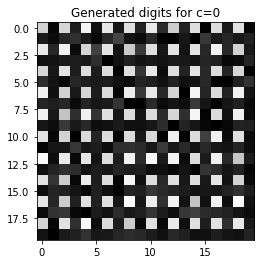

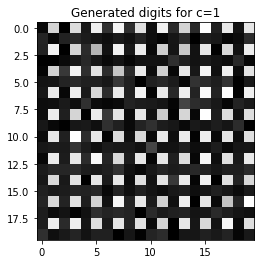

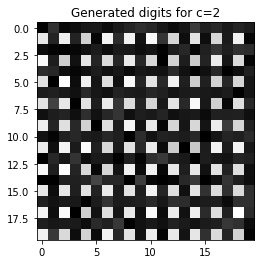

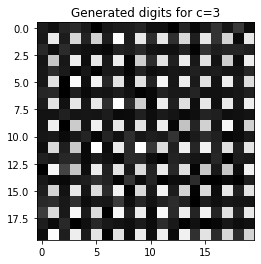

In [8]:
print("Calibration run - floating model")
for k in range(4):
    show_samples(model_floating, data, config, k)

In [9]:
print("Calibrated state dict with Observer")
print(model_floating.state_dict())

Calibrated state dict with Observer
OrderedDict([('cinn.module_list.1.perm', tensor([2, 3, 1, 0])), ('cinn.module_list.1.perm_inv', tensor([3, 2, 0, 1])), ('cinn.module_list.2.subnet1.quant.activation_post_process.eps', tensor([1.1921e-07])), ('cinn.module_list.2.subnet1.quant.activation_post_process.min_val', tensor(-1.0603)), ('cinn.module_list.2.subnet1.quant.activation_post_process.max_val', tensor(1.9254)), ('cinn.module_list.2.subnet1.lin_1.0.weight', tensor([[-6.3718e-02,  2.2704e-02,  1.5997e-02, -9.9484e-02, -4.8681e-40,
          8.9261e-02],
        [ 1.2351e-01, -7.3390e-02, -1.3032e-01, -1.1414e-01,  1.5680e-01,
          1.6682e-39],
        [ 9.0425e-03,  3.9725e-03,  2.2071e-32, -1.9854e-38,  1.7462e-05,
          9.9035e-03],
        [ 1.1287e-01,  1.0318e-01, -6.9996e-02, -9.0046e-02,  1.1976e-01,
          1.6756e-01],
        [ 1.0469e-01,  7.9483e-02, -9.0949e-02, -1.0548e-01,  1.3954e-01,
          1.9798e-01],
        [-7.5446e-02,  1.2797e-01, -7.1518e-02, -7.68

In [10]:
model_quant = torch.quantization.convert(model_floating, inplace=False)
print("Converted state dict")
print(model_quant.state_dict())

Converted state dict
OrderedDict([('cinn.module_list.1.perm', tensor([2, 3, 1, 0])), ('cinn.module_list.1.perm_inv', tensor([3, 2, 0, 1])), ('cinn.module_list.2.subnet1.quant.scale', tensor([0.0235])), ('cinn.module_list.2.subnet1.quant.zero_point', tensor([45])), ('cinn.module_list.2.subnet1.lin_1.scale', tensor(0.0050)), ('cinn.module_list.2.subnet1.lin_1.zero_point', tensor(0)), ('cinn.module_list.2.subnet1.lin_1._packed_params.dtype', torch.qint8), ('cinn.module_list.2.subnet1.lin_1._packed_params._packed_params', (tensor([[-0.0627,  0.0238,  0.0151, -0.0994,  0.0000,  0.0886],
        [ 0.1232, -0.0735, -0.1297, -0.1146,  0.1578,  0.0000],
        [ 0.0086,  0.0043,  0.0000,  0.0000,  0.0000,  0.0108],
        [ 0.1124,  0.1038, -0.0692, -0.0908,  0.1189,  0.1686],
        [ 0.1038,  0.0800, -0.0908, -0.1059,  0.1405,  0.1989],
        [-0.0757,  0.1275, -0.0713, -0.0778,  0.0000,  0.1708],
        [ 0.0843, -0.1470,  0.2183, -0.2313,  0.1275,  0.0324],
        [ 0.0519, -0.2205, 

Quantized model
1.0	0.0	0.0	0.0
0.0	1.0	0.0	0.0
0.0	0.0	1.0	0.0
0.0	0.0	0.0	1.0


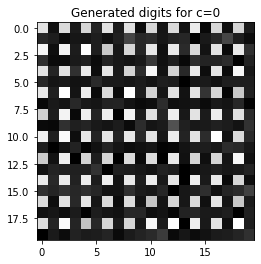

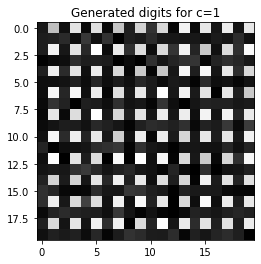

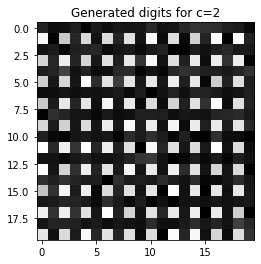

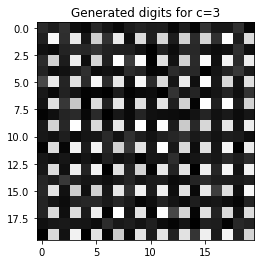

In [11]:
print("Quantized model")
for k in range(4):
    show_samples(model_quant, data, config, k)

In [12]:
model_quant.save("quantized_model.pt")

/opt/spack_views/visionary-dls/lib/python3.8/site-packages/torch/quantization/observer.py:121: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/opt/spack_views/visionary-dls/lib/python3.8/site-packages/torch/quantization/observer.py:243: UserWarning: must run observer before calling calculate_qparams.                                        Returning default scale and zero point 
  warnings.warn(


Loaded Quantized model
1.0	0.0	0.0	0.0
0.0	1.0	0.0	0.0
0.0	0.0	1.0	0.0
0.0	0.0	0.0	1.0


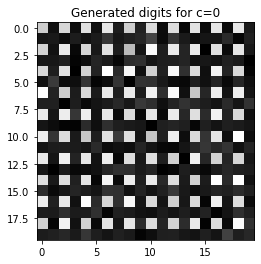

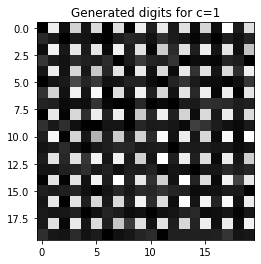

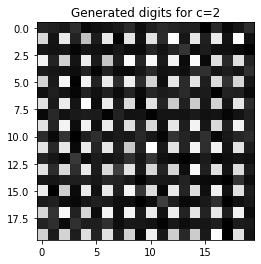

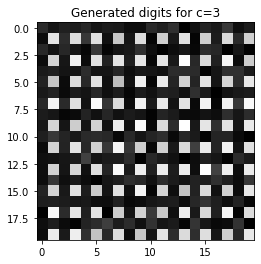

In [21]:
cpu_config = CONFIG
cpu_config.device = "cpu"
load_model = EXAMPLEcINN_minimal(cpu_config)
load_model.quantize()
load_model.load("quantized_model.pt")

print("Loaded Quantized model")
for k in range(4):
    show_samples(load_model, data, config, k)

Loaded Quantized model
1.0	0.0	0.0	0.0
0.0	1.0	0.0	0.0
0.0	0.0	1.0	0.0
0.0	0.0	0.0	1.0


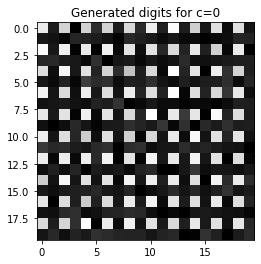

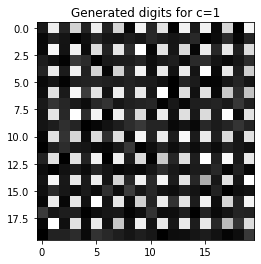

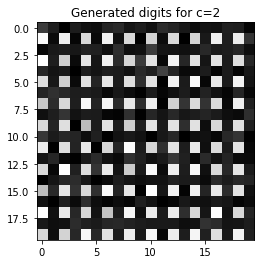

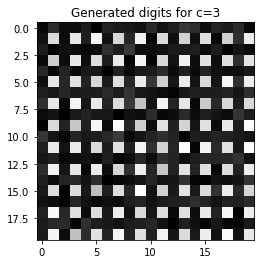

In [17]:
print("Loaded Quantized model")
for k in range(4):
    show_samples(load_model, data, config, k)


def calib_func(model, data=data, config=config):
    for k in range(4):
        show_samples(model, data, config, k)
